# Top Motifs

##  What is a motif?

A time series motif is a group of well conserved subsequences in a time series. The minimum of the matrix profile corresponds to the first motif pair. This algorithm exploits the Matrix Profile and MASS distance to find the nearest neighbor subsequences for the top motif pairs.

A great explanation is found in https://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf starting on slide 36.
## Load libraries

In [1]:
from matrixprofile import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Load data

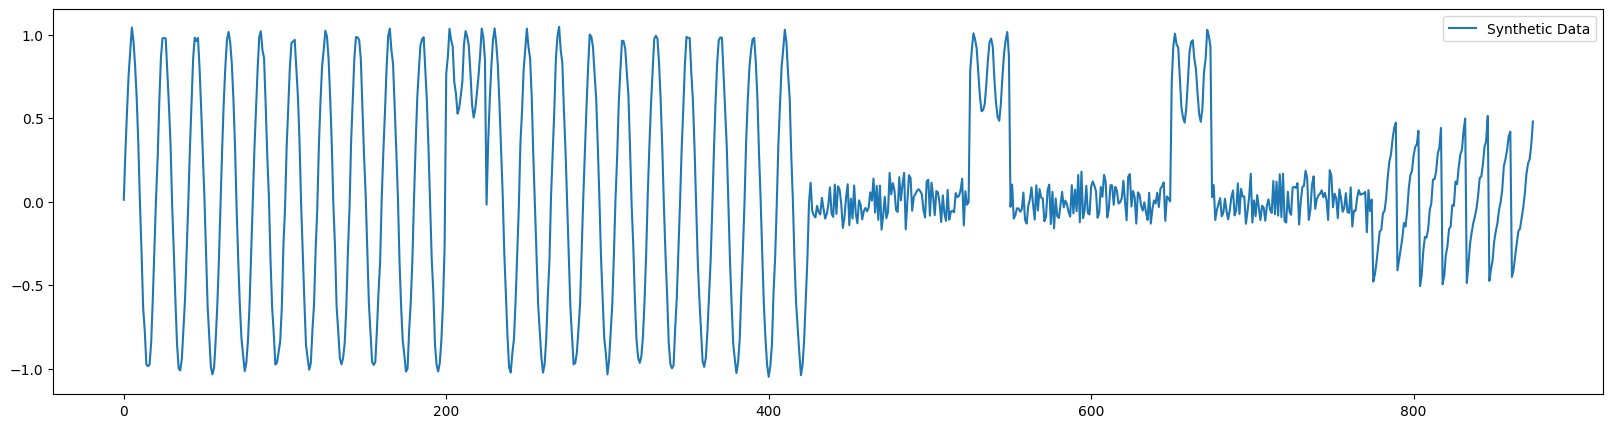

In [2]:
data = pd.read_csv('rawdata.csv')
pattern = data.data.values

#Plot data
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
legend = ax1.legend(loc='upper right')

## Create a function to find motif with the STMP algorithm

In [3]:
def motifs_stmp(ts, mp, max_motifs=3, v=1, radius=2, n_neighbors=None, ex_zone=None):
    """
    Our version. Find the motifs using STMP.
    
    Parameters
    ----------
    ts : array-like
        Original Time series 
    mp : tuple
        Matrix Profile (values and indexes)
    max_motifs : int
        The maximum number of motifs to discover 
    v : int
        Step size used in computing the Matrix Profile
    radius : float
        Expansion factor to find similiar motif
    n_neighbors : int
        Maximum number of neighbor to consider
    ex_zone : int
        The number of samples to exclude and set to Inf on either side of a found motifs
        defaults to m/2
        
    Returns
    -------
    tuple
        (motifs, distances)
    motifs: a list of lists of indexes representing the motif starting locations.
    distances: list of minimum distances for each motif
    """
    motifs = []
    distances = []
    
    try:
        mp_current1, mp_idx = mp
    except TypeError:
        raise ValueError("argument mp must be a tuple")
    
    mp_current = np.copy(mp_current1)
    n = len(ts)
    m = n - len(mp_current) + 1
    
    if ex_zone is None:
        ex_zone = int(m / 2)
    
    for j in range(max_motifs):
        # find minimum distance and index location
        min_idx = np.nanargmin(mp_current)
        min_val = mp_current[min_idx]
        
        if np.isinf(min_val) or np.isnan(min_val):
            break
        
        #to avoid working with zero distance 
        if min_val == 0.0:
            min_val += np.finfo(mp_current.dtype).eps
        
        # adding motif to the list
        motif_set = {min_idx}
        distances.append(min_val)
        
        # find the index of the closest match
        match_idx = int(mp_idx[min_idx])
        if not np.isinf(mp_current[match_idx]):
            motif_set.add(match_idx)
        
        # expand the mptif searching for similiar neighbors
        prof, _ = distanceProfile.massDistanceProfile(ts, min_idx, m, v, ts)
               
        
        # kill off any indices around the initial motif pair since they are
        # trivial solutions
        for idx in motif_set:
            _applyExclusionZone(prof, idx, ex_zone)
        
        # exclude previous motifs
        for ms in motifs:
            for idx in ms:
                _applyExclusionZone(prof, idx, ex_zone)
        
        # keep looking for the closest index to the current motif. Each
        # index found will have an exclusion zone applied as to remove
        # trivial solutions. This eventually exits when there's nothing
        # found within the radius distance.
        sorted_idx = np.argsort(prof)
        neighbor_count = 0
        
        for idx in sorted_idx:
            if n_neighbors is not None and neighbor_count >= n_neighbors:
                break
            
            
            # Sort and filter out non-finite values from the distance profile
            finite_prof = np.sort(prof[np.isfinite(prof)])
            if len(finite_prof) > 1:
            # Use the second smallest distance to compute a more realistic threshold.
            # This avoids using a threshold that is too small (e.g., zero or near-zero),
            # which can happen when the best match is a trivial or perfect match.
            # A too-small threshold can prevent motif discovery by being overly strict

                second_best = finite_prof[1]
                threshold = second_best * radius
            else:
                threshold = 1.5  # Fallback threshold if there are not enough valid distances 
            if prof[idx] > threshold:
                # If the current distance is too large compared to the threshold, stop the search
                break
            if not np.isinf(prof[idx]):
                motif_set.add(idx)
                neighbor_count += 1
                _applyExclusionZone(prof, idx, ex_zone)
                
            if prof[idx] == np.inf:
                continue
            if prof[idx] < min_val * radius:
                motif_set.add(idx)
                _applyExclusionZone(prof, idx, ex_zone)
            else:
                break
                
            
        
        motifs.append(sorted(motif_set))
        
        # apply the exclusion zone to the matrxix profile
        for idx in motif_set:
            _applyExclusionZone(mp_current, idx, ex_zone)
    
    return motifs, distances

def _applyExclusionZone(prof, idx, zone):
    """Apply an exclusion zone to the profile"""
    start = max(0, idx - zone)
    end = min(len(prof), idx + zone + 1)
    prof[start:end] = np.inf

def find_motifs_stmp(ts, m, v=1, max_motifs=3, radius=2, n_neighbors=None, ex_zone=None):
    """
    Find the motifs in a Time Series using STMP Matrix Profile"""
    
    mp = matrixProfile.stmp(ts, m, v)
    
    
    motifs, distances = motifs_stmp(ts, mp, max_motifs=max_motifs, v=v, 
                                  radius=radius, n_neighbors=n_neighbors, 
                                  ex_zone=ex_zone)
    
    return motifs, distances, mp

def plot_motifs(ts, motifs, mp, m,v):
    """Plot the results"""
    mp_values, mp_indices = mp
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    
    # Plot Matrix Profile
    if v==1:
        ax1.plot(mp_values)
        ax1.set_title(f'Matrix Profile (v={v})')
        ax1.grid(True)
    else:
        mp_full = np.full_like(mp_values, np.nan)
        valid_indices = np.arange(0, len(mp_values), v)

        mp_full[valid_indices] = mp_values[valid_indices]

        mp_filled = mp_full.copy()
        for i in range(1, len(mp_filled)):
            if np.isnan(mp_filled[i]):
                mp_filled[i] = mp_filled[i-1]
        ax1.plot(mp_filled)
        ax1.set_title(f'Matrix Profile (v={v})')
        ax1.grid(True)
    
    # Plot Time Series with motif
    ax2.plot(ts, color="lightgrey")
    ax2.set_title('Time Series with Motifs')
    ax2.grid(True)
    
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']
    
    for i, motif_group in enumerate(motifs):
        color = colors[i % len(colors)]
        for idx in motif_group:
            # extracting the corresponding segment of the motif
            segment = ts[idx:idx+m]

            ax2.plot(range(idx, idx+m), segment, 
                    color=color, 
                    linewidth=2,
                    label=f'Motif {i+1}' if idx == motif_group[0] else None)
    
    ax2.legend()
    plt.tight_layout()
    plt.show()

def print_motif_ranges(motifs, m):
    print("=== Motif Interval ===")
    for i, group in enumerate(motifs):
        print(f"\n● Motif Group {i+1}:")
        for j, idx in enumerate(group):
            print(f"  Segment {j+1}: [{idx}, {idx + m - 1}]")
    



## Calculate Matrix Profile and Motifs

### **v=1**

Grouped motifs: [[4, 24, 44, 64, 84, 104, 124, 144, 164, 229, 249, 269, 289, 309, 329, 349, 369, 389], [181, 406], [198, 423, 523, 648]]
=== Motif Interval ===

● Motif Group 1:
  Segment 1: [4, 35]
  Segment 2: [24, 55]
  Segment 3: [44, 75]
  Segment 4: [64, 95]
  Segment 5: [84, 115]
  Segment 6: [104, 135]
  Segment 7: [124, 155]
  Segment 8: [144, 175]
  Segment 9: [164, 195]
  Segment 10: [229, 260]
  Segment 11: [249, 280]
  Segment 12: [269, 300]
  Segment 13: [289, 320]
  Segment 14: [309, 340]
  Segment 15: [329, 360]
  Segment 16: [349, 380]
  Segment 17: [369, 400]
  Segment 18: [389, 420]

● Motif Group 2:
  Segment 1: [181, 212]
  Segment 2: [406, 437]

● Motif Group 3:
  Segment 1: [198, 229]
  Segment 2: [423, 454]
  Segment 3: [523, 554]
  Segment 4: [648, 679]


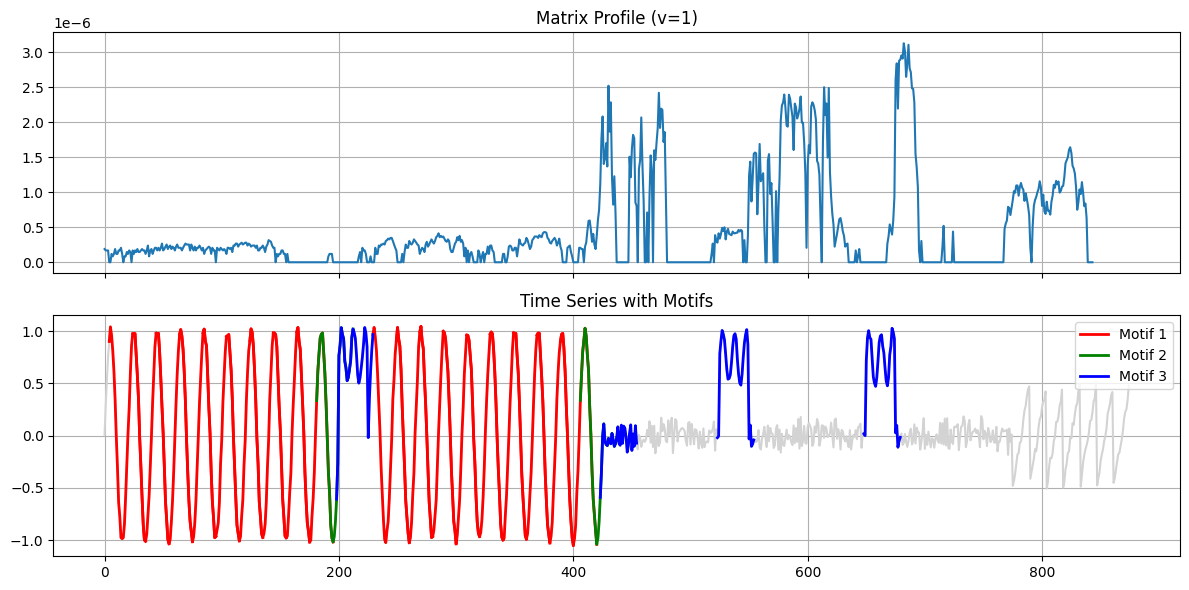

In [4]:
# parameters
m = 32
v = 1

# find motifs
motifs, distances, mp = find_motifs_stmp(
    ts=pattern,
    m=m,
    v=v,
    max_motifs=3,
    radius=1.2
)


print("Grouped motifs:", motifs)


print_motif_ranges(motifs, m=32)

plot_motifs(pattern, motifs, mp, m,v)

### **v=2**

Grouped motifs: [[0, 20, 40, 100, 160, 178], [58, 118, 138, 262, 302, 402], [76, 240, 280, 320, 340, 360]]
=== Motif Interval ===

● Motif Group 1:
  Segment 1: [0, 31]
  Segment 2: [20, 51]
  Segment 3: [40, 71]
  Segment 4: [100, 131]
  Segment 5: [160, 191]
  Segment 6: [178, 209]

● Motif Group 2:
  Segment 1: [58, 89]
  Segment 2: [118, 149]
  Segment 3: [138, 169]
  Segment 4: [262, 293]
  Segment 5: [302, 333]
  Segment 6: [402, 433]

● Motif Group 3:
  Segment 1: [76, 107]
  Segment 2: [240, 271]
  Segment 3: [280, 311]
  Segment 4: [320, 351]
  Segment 5: [340, 371]
  Segment 6: [360, 391]


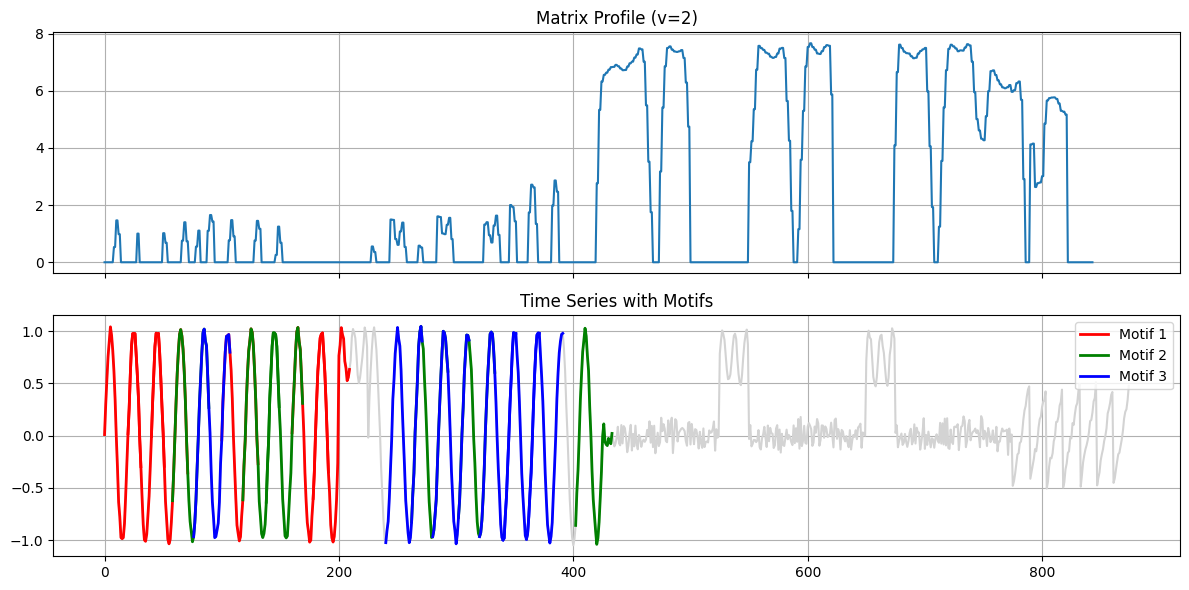

In [5]:
# Parameters
m = 32
v = 2

# find motifs
motifs, distances, mp = find_motifs_stmp(
    ts=pattern,
    m=m,
    v=v,
    max_motifs=3,
    radius=1.2
)


print("Grouped motifs:", motifs)


print_motif_ranges(motifs, m=32)

plot_motifs(pattern, motifs, mp, m,v)


# London Weather Dataset

In [6]:
london = pd.read_csv("london_weather.csv")
london['date'] = pd.to_datetime(london['date'])

min_temp = london['min_temp'].copy()

# find the indices for the missing values
nan_indices = min_temp[min_temp.isna()].index

for idx in nan_indices:
    if 0 < idx < len(min_temp) - 1:
        prev_val = min_temp.iloc[idx - 1]
        next_val = min_temp.iloc[idx + 1]
        if not pd.isna(prev_val) and not pd.isna(next_val):
            min_temp.iloc[idx] = (prev_val + next_val) / 2

london['min_temp'] = min_temp

weather_london = london['min_temp'].values

### **v=1**

Grouped motifs: [[0, 9, 94, 324], [20, 27, 105, 134, 157, 192, 310], [14, 31, 77, 304]]
=== Motif Interval ===

● Motif Group 1:
  Segment 1: [0, 6]
  Segment 2: [9, 15]
  Segment 3: [94, 100]
  Segment 4: [324, 330]

● Motif Group 2:
  Segment 1: [20, 26]
  Segment 2: [27, 33]
  Segment 3: [105, 111]
  Segment 4: [134, 140]
  Segment 5: [157, 163]
  Segment 6: [192, 198]
  Segment 7: [310, 316]

● Motif Group 3:
  Segment 1: [14, 20]
  Segment 2: [31, 37]
  Segment 3: [77, 83]
  Segment 4: [304, 310]


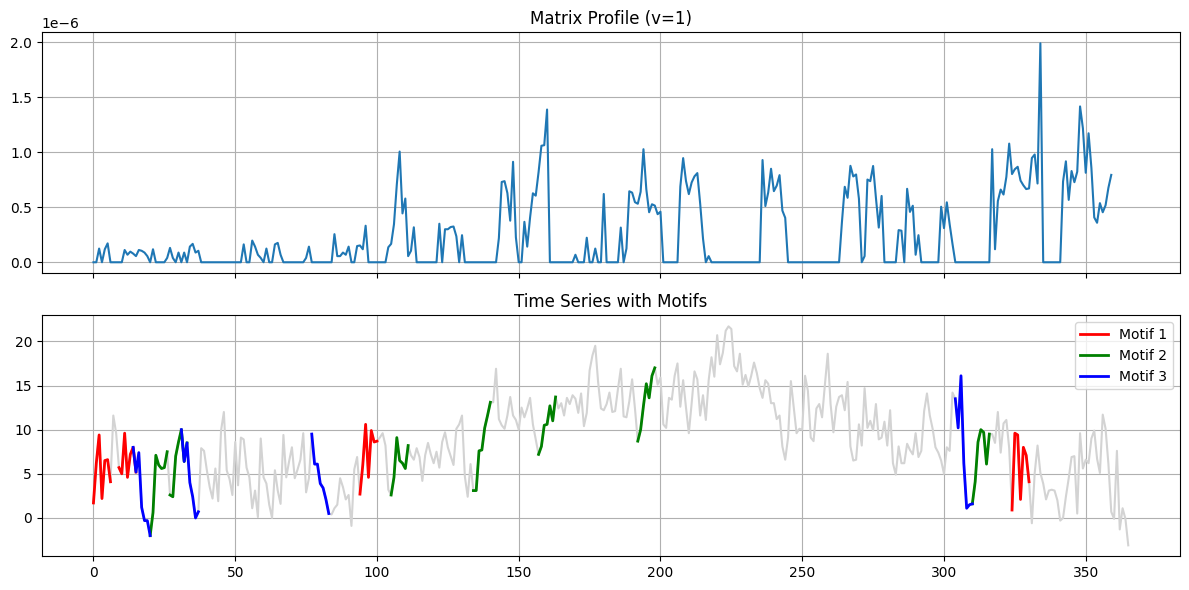

In [7]:
# Parameters
m = 7
v = 1

# find motifs
motifs_l, distances_l, mp_l = find_motifs_stmp(
    ts=weather_london,
    m=m,
    v=v,
    max_motifs=3,
    radius=3
)


print("Grouped motifs:", motifs_l)

print_motif_ranges(motifs_l, m=7)

plot_motifs(weather_london, motifs_l, mp_l, m,v)

### **v=2**

Grouped motifs: [[2, 120, 148], [6, 194, 248], [24, 72, 128, 216, 256]]
=== Motif Interval ===

● Motif Group 1:
  Segment 1: [2, 8]
  Segment 2: [120, 126]
  Segment 3: [148, 154]

● Motif Group 2:
  Segment 1: [6, 12]
  Segment 2: [194, 200]
  Segment 3: [248, 254]

● Motif Group 3:
  Segment 1: [24, 30]
  Segment 2: [72, 78]
  Segment 3: [128, 134]
  Segment 4: [216, 222]
  Segment 5: [256, 262]


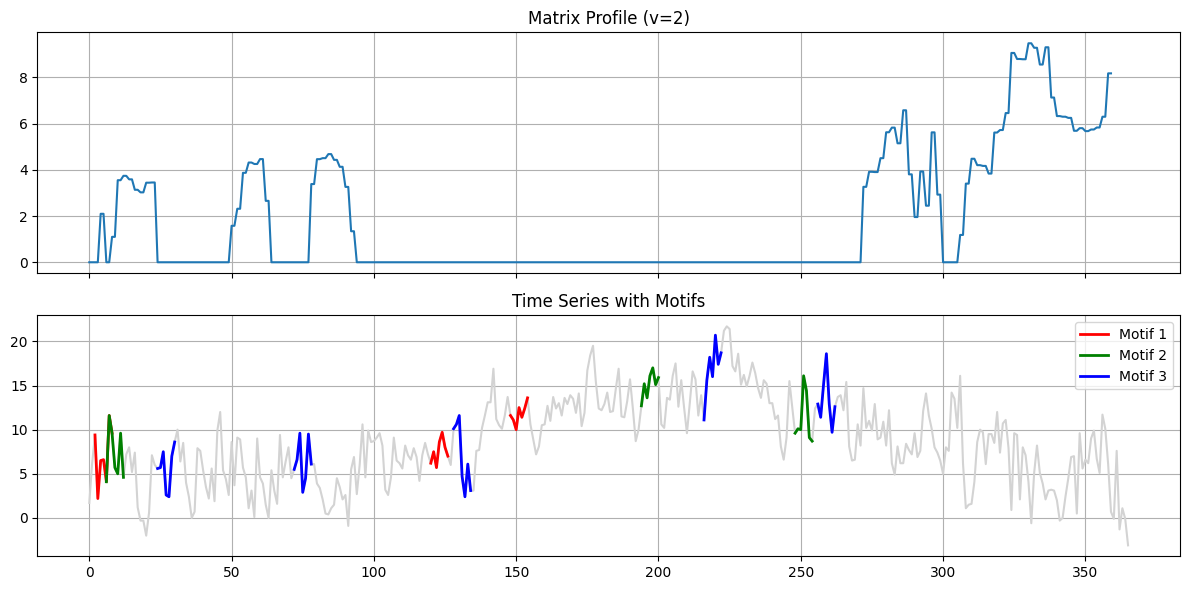

In [8]:
# Parameters
m = 7
v = 2

# find motifs
motifs_l2, distances_l2, mp_l2 = find_motifs_stmp(
    ts=weather_london,
    m=m,
    v=v,
    max_motifs=3,
    radius=1.2
)


print("Grouped motifs:", motifs_l2)


print_motif_ranges(motifs_l2, m=7)

plot_motifs(weather_london, motifs_l2, mp_l2, m,v)